In [22]:
import os
import sys
import math

import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.compute_overlap import *
from utils.compute_overlap_mpi import *

def read_xyz(xyzpath:str):
    '''read xyz file and return a list of symbols and a list of coordinates'''
    with open(xyzpath, 'r') as f:
        lines = f.readlines()
    symbols = []
    coords = []
    for line in lines[2:]:
        symbol, *coord = line.split()
        symbols.append(symbol)
        coords.append([float(c) for c in coord])
    return np.array(symbols, dtype = np.dtype("S")), np.array(coords)

def atomwised_coulombic_interaction(xyz1, chg1, xyz2, chg2):
    """Compute the coulombic interaction between two molecules
    """
    # change the unit from angstrom to bohr
    xyz1 = xyz1 / 0.529177
    xyz2 = xyz2 / 0.529177
    # compute the distance matrix
    dist = np.linalg.norm(xyz1[:,None,:] - xyz2[None,:,:], axis = -1)
    # compute the coulombic interaction
    cmat = chg1[:,None] * chg2[None,:] / dist
    coul1 = np.sum(cmat, axis = 0) / 2
    coul2 = np.sum(cmat, axis = 1) / 2
    return coul1, coul2

def atomwised_coulombic_interaction_3rd(xyz1, xyz2, chg1s, chg2s):
    """Compute the coulombic interaction between two molecules
    """
    # change the unit from angstrom to bohr
    xyz1 = xyz1 / 0.529177
    xyz2 = xyz2 / 0.529177
    # compute the distance matrix
    dist = np.linalg.norm(xyz1[:,None,:] - xyz2[None,:,:], axis = -1)
    coul1s, coul2s = [], []
    for chg1, chg2 in zip(chg1s, chg2s):
        # compute the coulombic interaction
        cmat = chg1[:,None] * chg2[None,:] / dist
        coul1 = np.sum(cmat, axis = 0) / 2
        coul2 = np.sum(cmat, axis = 1) / 2
        coul1s.append(coul1)
        coul2s.append(coul2)
    return coul1s, coul2s




In [23]:
# define monomer
monomername = "tetracene"
monomernatom = 30           
n_le = 1

# specify the dataset: perylene tetramer (oPrTet)
num_monomer_per_aggregate = 2
dataset_name = "oTtDim"
dataset_folder = f"data/oos-{monomername}"

te_lect2ctct_fact = 0.76
th_lect2ctct_fact = 1.20

# read monomer data, include reference xyz, charges, and energies
monomerfolder = "data/monomer"
chgsuffixes = ["trespchg", "cation-respchg", "anion-respchg"]
chgdatas = [np.zeros(monomernatom) for i in range(len(chgsuffixes))]
for i in range(len(chgsuffixes)):
    chgdata = pd.read_csv(os.path.join(monomerfolder, f"{monomername}-{chgsuffixes[i]}.csv"))
    chgdatas[i] = chgdata.loc[:,"q"].values

import mdtraj as md 
# load structures
xyzpath = dataset_folder + "/" + dataset_name + ".h5"
xyzconf = md.load_hdf5(xyzpath).xyz * 10.0  # nm to angstrom

ref_symbols, ref_coords = read_xyz(f"{monomerfolder}/{monomername}.xyz")

In [24]:
# read xyz structures split them into monomers
coordinates = []
species = []
n_monomers = []
for i, xyz in enumerate(xyzconf):
    symbols = np.concatenate([ref_symbols for i in range(num_monomer_per_aggregate)])
    # split into monomers
    n_monomer = len(xyz) // monomernatom
    n_monomers.append(n_monomer)
    for j in range(n_monomer):
        coordinates.append(xyz[j*monomernatom:(j+1)*monomernatom])
        species.append(symbols[j*monomernatom:(j+1)*monomernatom])

# convert to numpy array
coordinates = np.array(coordinates)
species = np.array(species)
n_monomers = np.array(n_monomers)
aggregate_idx = np.cumsum(n_monomers)
aggregate_idx.shape, coordinates.shape
n_aggregate = len(aggregate_idx)

# generate monomer pairs
monomer_pairs = []
pair_aggregate_idx = []
lastidx = 0
for o, i in enumerate(aggregate_idx):
    for j in range(lastidx, i):
        for k in range(j+1, i):
            monomer_pairs.append((j,k))
            pair_aggregate_idx.append(o)
    lastidx = i
monomer_pairs = np.array(monomer_pairs)
pair_aggregate_idx = np.array(pair_aggregate_idx)
monomer_pairs.shape


(500, 2)

In [25]:
# compute pairwise approximations
trespchgs = chgdatas[0]
caespchgs = chgdatas[1]
anespchgs = chgdatas[2]

n_pairs = len(monomer_pairs)

atmapx_v_1p2m = np.empty((n_pairs, monomernatom*2))
atmapx_v_1m2p = np.empty((n_pairs, monomernatom*2))
atmapx_1e12e1 = np.empty((n_pairs, monomernatom*2))
atmapx_1e11p2m = np.empty((n_pairs, monomernatom*2))
atmapx_1e11m2p = np.empty((n_pairs, monomernatom*2))

for i in tqdm.tqdm(range(n_pairs)):
    idx, jdx = monomer_pairs[i]
    xyz1 = coordinates[idx]
    xyz2 = coordinates[jdx]

    apxis, apxjs = atomwised_coulombic_interaction_3rd(
        xyz1, xyz2, 
        [trespchgs, caespchgs, anespchgs], 
        [trespchgs, anespchgs, caespchgs])
    atmapx_1e12e1[i] = np.concatenate((apxis[0], apxjs[0]), axis = 0) * 27.2114 * 1000
    atmapx_v_1p2m[i] = np.concatenate((apxis[1], apxjs[1]), axis = 0) * 27.2114 * 1000
    atmapx_v_1m2p[i] = np.concatenate((apxis[2], apxjs[2]), axis = 0) * 27.2114 * 1000


    # apxi, apxj = atomwised_coulombic_interaction(xyz1, trmulchgs, xyz2, trmulchgs)
    # atmapx_1e12e1[i] = np.concatenate((apxi, apxj)) * 27.2114 * 1000
    # apxi, apxj = atomwised_coulombic_interaction(xyz1, caespchgs, xyz2, anespchgs)
    # atmapx_v_1p2m[i] = np.concatenate((apxi, apxj)) * 27.2114 * 1000
    # apxi, apxj = atomwised_coulombic_interaction(xyz1, anespchgs, xyz2, caespchgs)
    # atmapx_v_1m2p[i] = np.concatenate((apxi, apxj)) * 27.2114 * 1000

    
# compute overlap integrals, batch input to avoid memory overflow
# if False:
if os.path.exists(os.path.join(dataset_folder, f"{dataset_name}-atmovlphmo.csv")) and os.path.exists(os.path.join(dataset_folder, f"{dataset_name}-atmovlplmo.csv")):
    atmapx_1e11p2m = pd.read_csv(f"{dataset_folder}/{dataset_name}-atmovlplmo.csv", index_col = 0)
    atmapx_1e11m2p = pd.read_csv(f"{dataset_folder}/{dataset_name}-atmovlphmo.csv", index_col = 0)
else:
    from compute_overlap_mpi import *
    atmapx_1e11p2m = pd.DataFrame(index = range(monomernatom*2), columns = range(n_pairs))
    atmapx_1e11m2p = pd.DataFrame(index = range(monomernatom*2), columns = range(n_pairs))

    batch_size = 4096
    batch_idx = np.arange(0, n_pairs, batch_size)
    batch_idx = np.append(batch_idx, n_pairs)
    for i in tqdm.tqdm(range(len(batch_idx)-1)):
        idx1 = batch_idx[i]
        idx2 = batch_idx[i+1]
        xyz1 = coordinates[monomer_pairs[idx1:idx2,0]]
        xyz2 = coordinates[monomer_pairs[idx1:idx2,1]]
        species1 = species[monomer_pairs[idx1:idx2,0]]
        species2 = species[monomer_pairs[idx1:idx2,1]]
        # compute overlap integrals
        atmovlphmo, atmovlplmo = compute_overlap_main(
            np.concatenate((xyz1, xyz2), axis = 1),
            f"{monomerfolder}/{monomername}.molden",
            20,
            outputfolder = os.getcwd() + "/tmp",
        )
        atmapx_1e11p2m.iloc[:,idx1:idx2] = atmovlplmo.values
        atmapx_1e11m2p.iloc[:,idx1:idx2] = atmovlphmo.values
    atmapx_1e11m2p.to_csv(os.path.join(dataset_folder, f"{dataset_name}-atmovlphmo.csv"))
    atmapx_1e11p2m.to_csv(os.path.join(dataset_folder, f"{dataset_name}-atmovlplmo.csv"))

atmapx_1e11m2p = atmapx_1e11m2p.values.T * 1000 * -1
atmapx_1e11p2m = atmapx_1e11p2m.values.T * 1000 *  1

100%|██████████| 500/500 [00:00<00:00, 4062.31it/s]


In [26]:
import torch
import torchani
import torch.utils.tensorboard

from nnp_models import *

def atomwised_coulombic_interaction_torch(xyz1:torch.Tensor, chg1:torch.Tensor, xyz2:torch.Tensor, chg2:torch.Tensor):
    """Compute the coulombic interaction between two molecules
    """
    # change the unit from angstrom to bohr
    xyz1 = xyz1 / 0.529177
    xyz2 = xyz2 / 0.529177
    # compute the distance matrix
    dist = torch.cdist(xyz1, xyz2)
    # compute the coulombic interaction
    cmat = chg1[:,None] * chg2[None,:] / dist
    coul1 = torch.sum(cmat, dim = 0) / 2
    coul2 = torch.sum(cmat, dim = 1) / 2
    return coul1, coul2

# initialize machine learning model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
monomer_nnp_params = {
    "elements": ["H", "C",],
    "hidden_channels": [256, 256, 256],
    "output_channels": 3,   # monomer properties
    "approx_channels": 0,
    "Rcr": 7.5000e+00, "EtaR": 1.6000000e+01, 
    "ShfR_min": 0.9, "ShfR_n": 16,
    "Rca": 3.5000e+00, "EtaA": 8.0000000e+00,
    "ShfA_min": 0.9, "ShfA_n": 4 ,
    "Zeta": 3.2000000e+01, "ShfZ_n": 8,
}
interaction_nnp_params = {
    "elements": ["H", "C",],
    "hidden_channels": [64, 64, 64],
    "output_channels": 5,   # interaction properties
    "approx_channels": 4,   # approximations
    "Rcr": 7.5000e+00, "EtaR": 1.6000000e+01, 
    "ShfR_min": 0.9, "ShfR_n": 16,
    "Rca": 3.5000e+00, "EtaA": 8.0000000e+00,
    "ShfA_min": 0.9, "ShfA_n": 4 ,
    "Zeta": 3.2000000e+01, "ShfZ_n": 8,
}

use_belonging   = True
dimer_aev       = False
modified_aev    = False
s1 = "u" if use_belonging else "o"
s2 = "d" if dimer_aev     else "o"
s3 = "m" if modified_aev  else "o"
suffix = f"{s1}{s2}{s3}"
# model_prefix = f"{monomername}-{suffix}"
model_name = f"{monomername}-best"
model_folder = "models" 

model = ExmodSeparateNNP(
    device   = device,
    monomer_nnp_params     = monomer_nnp_params,
    interaction_nnp_params = interaction_nnp_params,
    use_belonging          = use_belonging,
    dimer_aev              = dimer_aev,
    modified_aev           = modified_aev,
    # return_monomer_terms   = False,
    return_monomer_terms   = True,
)
model.load_state_dict(torch.load(f"{model_folder}/{model_name}.pt", map_location = device))
model.to(device)
model.eval()
"" 

Initializing monomer models
Initializing interaction models
Initializing cation models
Initializing anion models
Initializing interaction models


''

In [27]:

# evaluate the model
target_property = [
        "1e(1)", "1+2-", "1e(1)2e(1)", "1e(1)1+2-", "1e(1)1-2+"  # off-diagonal terms
]
approx_property = [
    "atmapx_v_1+2-",        # coulomb interaction between monomers at 1+2- charge transfer state
    "atmapx_1e(1)2e(1)",    # transition density interaction between the two local excited states
    "atmapx_1e(1)1+2-",     # overlap integral between the two monomers (lumo)
    "atmapx_1e(1)1-2+"      # overlap integral between the two monomers (hmmo) # This is not the correct abbreviation
]

# define fixed variables
species_order = model.monomer_nnp_params["elements"]
pair_belongings = np.concatenate((np.ones(monomernatom), np.ones(monomernatom)*2)).astype(np.int64)
pair_delongings = np.concatenate((np.ones(monomernatom)*2, np.ones(monomernatom))).astype(np.int64)
pair_belongings = np.tile(pair_belongings, (n_pairs, 1))
pair_delongings = np.tile(pair_delongings, (n_pairs, 1))
pair_belongings = torch.from_numpy(pair_belongings).to(device)
pair_delongings = torch.from_numpy(pair_delongings).to(device)

pair_species = np.array([species_order.index(e.decode()) for e in species[0]] * 2).astype(np.int64)
pair_species = np.tile(pair_species, (n_pairs, 1))
pair_species = torch.from_numpy(pair_species).to(device)

coordinates = torch.tensor(coordinates, device = device, dtype = torch.float32)

In [28]:
# constructe an dataframe to store the output
from itertools import product 

le_terms = ["1e(1)", "2e(1)"]
ct_terms = ["1+2-", "1-2+"]
terms = le_terms + ct_terms
tuples = list(product(terms, terms))
indexs = pd.MultiIndex.from_tuples(tuples, names = ["monomer1", "monomer2"])
pred_df = pd.DataFrame(index = indexs, columns = np.arange(n_pairs), dtype = float).fillna(0.0)
gasp_df = pd.DataFrame(index = [t + "g" for t in le_terms], columns = np.arange(n_pairs), dtype = float).fillna(0.0)

# concatentate all approximations for symmetry 1
approximations = np.stack((
    atmapx_v_1p2m,
    atmapx_1e12e1,
    atmapx_1e11p2m,
    atmapx_1e11m2p,
), axis = -1).astype(np.float32)
approximations = torch.from_numpy(approximations).to(device)

# start evaluate symmetry 1
batch_size = 64
batch_idx = np.arange(0, n_pairs, batch_size)
batch_idx = np.append(batch_idx, n_pairs)


In [29]:

for i in tqdm.tqdm(range(len(batch_idx)-1)):
    batch_slice = slice(batch_idx[i], batch_idx[i+1])
    pairs = monomer_pairs[batch_slice]
    batch_xyz = torch.cat((coordinates[pairs[:,0]], coordinates[pairs[:,1]]), dim = 1)
    batch_approxs = approximations[batch_slice]             
    batch_species = pair_species[batch_slice]
    batch_belongings = pair_belongings[batch_slice]

    # predict terms: 1e(1), 1+2-, 1e(1)2e(1), 1e(1)1+2-, 1e(1)1-2+
    pred_terms = model(batch_species, batch_xyz, batch_belongings, batch_approxs)
    pred_terms = pred_terms.detach().cpu().numpy()
    pred_germs = pred_terms[:,:3]
    pred_terms = pred_terms[:,3:]

    # store the output
    batch_slice_ = slice(batch_idx[i], batch_idx[i+1] - 1)
    pred_df.loc[("1e(1)", "1e(1)"), batch_slice_] = pred_terms[:,0]
    pred_df.loc[("1+2-", "1+2-"),   batch_slice_] = pred_terms[:,1]
    pred_df.loc[("1e(1)", "2e(1)"), batch_slice_] = pred_terms[:,2]
    pred_df.loc[("1e(1)", "1+2-"),  batch_slice_] = pred_terms[:,3]
    pred_df.loc[("1e(1)", "1-2+"),  batch_slice_] = pred_terms[:,4]
    pred_df.loc[("1+2-", "1e(1)"),  batch_slice_] = pred_terms[:,3]
    pred_df.loc[("1-2+", "1e(1)"),  batch_slice_] = pred_terms[:,4]

    gasp_df.loc["1e(1)g", batch_slice_] = pred_germs[:,0]

# concatentate all approximations for symmetry 2
approximations = np.stack((
    atmapx_v_1m2p,
    atmapx_1e12e1,
    atmapx_1e11p2m,
    atmapx_1e11m2p,
), axis = -1).astype(np.float32)
approximations = torch.from_numpy(approximations).to(device)

# start evaluate symmetry 2
batch_size = 64
batch_idx = np.arange(0, n_pairs, batch_size)
batch_idx = np.append(batch_idx, n_pairs)
for i in tqdm.tqdm(range(len(batch_idx)-1)):
    batch_slice = slice(batch_idx[i], batch_idx[i+1])
    pairs = monomer_pairs[batch_slice]
    batch_xyz = torch.cat((coordinates[pairs[:,0]], coordinates[pairs[:,1]]), dim = 1)
    batch_approxs = approximations[batch_slice]             
    batch_species = pair_species[batch_slice]
    batch_delongings = pair_delongings[batch_slice]
    
    # predict terms: 2e(1), 1-2+, 2e(1)1e(1), 2e(1)1-2+, 2e(1)1+2-
    pred_terms = model(batch_species, batch_xyz, batch_delongings, batch_approxs)
    pred_terms = pred_terms.detach().cpu().numpy()
    pred_germs = pred_terms[:,:3]
    pred_terms = pred_terms[:,3:]

    # store the output
    batch_slice_ = slice(batch_idx[i], batch_idx[i+1] - 1)
    pred_df.loc[("2e(1)", "2e(1)"), batch_slice_] = pred_terms[:,0]
    pred_df.loc[("1-2+", "1-2+"),   batch_slice_] = pred_terms[:,1]
    pred_df.loc[("2e(1)", "1e(1)"), batch_slice_] = pred_terms[:,2]
    pred_df.loc[("2e(1)", "1-2+"),  batch_slice_] = pred_terms[:,3]
    pred_df.loc[("2e(1)", "1+2-"),  batch_slice_] = pred_terms[:,4]
    pred_df.loc[("1-2+", "2e(1)"),  batch_slice_] = pred_terms[:,3]
    pred_df.loc[("1+2-", "2e(1)"),  batch_slice_] = pred_terms[:,4]

    gasp_df.loc["2e(1)g", batch_slice_] = pred_germs[:,0]

100%|██████████| 8/8 [00:00<00:00,  8.23it/s]


In [30]:
def create_term_labels(n_monomer = 2, n_le = 1):
    terms = []
    for i in range(n_monomer):
        for j in range(n_le):
            terms.append(f"{i+1}e({j+1})")
    for i in range(n_monomer):
        for j in range(i+1, n_monomer):
            terms.append(f"{i+1}+{j+1}-")
            terms.append(f"{i+1}-{j+1}+")
    return terms

def compute_term_index(n, m1, m2):
    if m2 == -1 or m1 == m2:
        return m1 - 1
    flg, m1, m2 = (0, m1, m2) if m1 < m2 else (1, m2, m1)
    bid = (2*n-m1)*(m1-1) + 2*(m2-m1-1) + flg
    return n + bid

def compute_term_index_array(n, m1, m2):
    flg = np.where(m1 < m2, 0, 1)
    m1_new, m2_new = np.where(m1 < m2, m1, m2), np.where(m1 < m2, m2, m1)
    m1_equals_m2 = np.where(m1 == m2, m1 - 1, np.nan)
    bid = (2*n - m1_new) * (m1_new - 1) + 2 * (m2_new - m1_new - 1) + flg
    other_cases = n + bid
    result = np.nan_to_num(m1_equals_m2, nan=other_cases)
    return result.astype(int)

def compute_1e12e1_xyindex_array(n, m1, m2):
    return m1 - 1, m2 - 1

def compute_1e11p2m_xyindex_array(n, m1, m2):
    x = m1 - 1
    y = n + (2*n - m1) * (m1 - 1) + 2 * (m2 - m1 - 1)
    return x, y 

def compute_1e11m2p_xyindex_array(n, m1, m2):
    x = m1 - 1
    y = n + (2*n - m1) * (m1 - 1) + 2 * (m2 - m1 - 1) + 1
    return x, y

def compute_2e11p2m_xyindex_array(n, m1, m2):
    x = m2 - 1
    y = n + (2*n - m1) * (m1 - 1) + 2 * (m2 - m1 - 1)
    return x, y

def compute_2e11m2p_xyindex_array(n, m1, m2):
    x = m2 - 1
    y = n + (2*n - m1) * (m1 - 1) + 2 * (m2 - m1 - 1) + 1
    return x, y

def preprocess_indexs(pairindex):
    p = pairindex + 1
    n = p.max()
    q = p[:,::-1]
    newarray = np.zeros((n + p.shape[0] * 2, 2), dtype = int)
    newarray[:n,0] = np.arange(1, n+1)
    newarray[:n,1] = np.arange(1, n+1)
    newarray[n  ::2,:] = p
    newarray[n+1::2,:] = q
    return newarray


In [31]:
aggregate_hamiltonianss = []
for i in range(n_aggregate):
    n_monomer = n_monomers[i]
    terms = create_term_labels(n_monomer, n_le)
    hamiltonian = np.zeros((len(terms), len(terms)), dtype = float)
    aggregate_hamiltonianss.append(hamiltonian)

# assign the site energy terms
curpairidx = 0
curmonomer = 0
pbar1 = tqdm.tqdm(total = len(monomer_pairs))
for i, aggsize in enumerate(n_monomers):
    n_pair = aggsize * (aggsize - 1) // 2
    pairs = monomer_pairs[curpairidx:curpairidx+n_pair] - curmonomer + 1
    dim_hamts = pred_df.loc[(slice(None), slice(None)), curpairidx:curpairidx+n_pair-1]
    gas_datas = gasp_df.loc[(slice(None)), curpairidx:curpairidx+n_pair-1]
    agg_hamt = aggregate_hamiltonianss[i]

    x_2e1 = pairs[:,1] - 1
    x_1e1 = pairs[:,0] - 1
    _, x_1p2m = compute_1e11p2m_xyindex_array(aggsize, pairs[:,0], pairs[:,1])
    _, x_1m2p = compute_1e11m2p_xyindex_array(aggsize, pairs[:,0], pairs[:,1])

    agg_hamt[x_1e1,  x_1e1 ] = gas_datas.loc["1e(1)g", :].values
    agg_hamt[x_2e1,  x_2e1 ] = gas_datas.loc["2e(1)g", :].values
    agg_hamt[x_1p2m, x_1p2m] = dim_hamts.loc[("1+2-" , "1+2-"), :].values
    agg_hamt[x_1m2p, x_1m2p] = dim_hamts.loc[("1-2+" , "1-2+"), :].values
    
    pbar1.update(n_pair)
    curmonomer += aggsize
    curpairidx += n_pair
pbar1.close()

# correct the LE terms
delta_1e1 = pred_df.loc[("1e(1)", "1e(1)"), :].values - gasp_df.loc["1e(1)g", :].values
delta_2e1 = pred_df.loc[("2e(1)", "2e(1)"), :].values - gasp_df.loc["2e(1)g", :].values
curpairidx = 0
curmonomer = 0
pbar1 = tqdm.tqdm(total = len(monomer_pairs))
for i, aggsize in enumerate(n_monomers):
    n_pair = aggsize * (aggsize - 1) // 2
    pairs = monomer_pairs[curpairidx:curpairidx+n_pair] - curmonomer + 1
    agg_hamt = aggregate_hamiltonianss[i]
    delta_1e1_ = delta_1e1[curpairidx:curpairidx+n_pair]
    delta_2e1_ = delta_2e1[curpairidx:curpairidx+n_pair]
    x_1e1 = pairs[:,0] - 1
    x_2e1 = pairs[:,1] - 1
    for j, (x1, x2) in enumerate(zip(x_1e1, x_2e1)):
        agg_hamt[x1, x1] += delta_1e1_[j]
        agg_hamt[x2, x2] += delta_2e1_[j]
    
    pbar1.update(n_pair)
    curmonomer += aggsize
    curpairidx += n_pair
pbar1.close()


# assign the LE-LE and LE-CT coupling terms
curpairidx = 0
curmonomer = 0
pbar1 = tqdm.tqdm(total = len(monomer_pairs))
for i, aggsize in enumerate(n_monomers):
    n_pair = aggsize * (aggsize - 1) // 2
    pairs = monomer_pairs[curpairidx:curpairidx+n_pair] - curmonomer + 1
    dim_hamts = pred_df.loc[(slice(None), slice(None)), curpairidx:curpairidx+n_pair-1]
    agg_hamt = aggregate_hamiltonianss[i]

    x_1e12e1 , y_1e12e1  = compute_1e12e1_xyindex_array (aggsize, pairs[:,0], pairs[:,1])
    x_1e11p2m, y_1e11p2m = compute_1e11p2m_xyindex_array(aggsize, pairs[:,0], pairs[:,1])
    x_1e11m2p, y_1e11m2p = compute_1e11m2p_xyindex_array(aggsize, pairs[:,0], pairs[:,1])
    x_2e11p2m, y_2e11p2m = compute_2e11p2m_xyindex_array(aggsize, pairs[:,0], pairs[:,1])
    x_2e11m2p, y_2e11m2p = compute_2e11m2p_xyindex_array(aggsize, pairs[:,0], pairs[:,1])

    agg_hamt[x_1e12e1, y_1e12e1]   = dim_hamts.loc[("1e(1)", "2e(1)"),:].values
    agg_hamt[x_1e11p2m, y_1e11p2m] = dim_hamts.loc[("1e(1)", "1+2-"), :].values
    agg_hamt[x_1e11m2p, y_1e11m2p] = dim_hamts.loc[("1e(1)", "1-2+"), :].values
    agg_hamt[x_2e11p2m, y_2e11p2m] = dim_hamts.loc[("2e(1)", "1+2-"), :].values
    agg_hamt[x_2e11m2p, y_2e11m2p] = dim_hamts.loc[("2e(1)", "1-2+"), :].values
    pbar1.update(n_pair)
    curmonomer += aggsize
    curpairidx += n_pair
pbar1.close()

100%|██████████| 500/500 [00:00<00:00, 776.58it/s]


In [32]:
def get_1same_triples_vectorized(monomer_pairs):
    n_pair = monomer_pairs.shape[0]
    idx1, idx2 = np.triu_indices(n_pair, k=1)

    triples = []
    
    p1 = monomer_pairs[idx1]
    p2 = monomer_pairs[idx2]

    cond1 = (p1[:,0] == p2[:,0]) & (p1[:,1] != p2[:,1])
    cond2 = (p1[:,0] == p2[:,1]) & (p1[:,1] != p2[:,0])
    cond3 = (p1[:,1] == p2[:,0]) & (p1[:,0] != p2[:,1])
    cond4 = (p1[:,1] == p2[:,1]) & (p1[:,0] != p2[:,0])

    valid1 = np.where(cond1)[0]
    triples1 = np.stack((p1[valid1, 0], p1[valid1, 1], p2[valid1, 1]), axis = -1)
    triples.append(triples1)

    valid2 = np.where(cond2)[0]
    triples2 = np.stack((p1[valid2, 0], p1[valid2, 1], p2[valid2, 0]), axis = -1)
    triples.append(triples2)

    valid3 = np.where(cond3)[0]
    triples3 = np.stack((p1[valid3, 1], p1[valid3, 0], p2[valid3, 1]), axis = -1)
    triples.append(triples3)

    valid4 = np.where(cond4)[0]
    triples4 = np.stack((p1[valid4, 1], p1[valid4, 0], p2[valid4, 0]), axis = -1)
    triples.append(triples4)

    return np.concatenate(triples, axis = 0)

In [33]:
# add the impact of monomer to the diagonal terms
pbar3 = tqdm.tqdm(total = len(n_monomers))
curpairidx = 0
curpairsum = 0
for i, aggsize in enumerate(n_monomers):
    n_pair = aggsize * (aggsize - 1) // 2
    agg_hamt = aggregate_hamiltonianss[i]
    pairs = monomer_pairs[curpairidx:curpairidx+n_pair] - curpairsum + 1
    triples = get_1same_triples_vectorized(pairs)

    dim_hamts = pred_df.loc[(slice(None), slice(None)), curpairidx:curpairidx+n_pair-1]
    m0s, m1s, m2s = triples[:,0], triples[:,1], triples[:,2]

    flag_ct1_0p1m = np.nonzero(m0s < m1s)
    flag_ct1_1m0p = np.nonzero(m0s > m1s)
    _, x_ct1_0p1m = compute_1e11p2m_xyindex_array(aggsize, m0s, m1s)
    _, x_ct1_1m0p = compute_1e11m2p_xyindex_array(aggsize, m1s, m0s)
    x_ct1 = np.zeros_like(m0s)
    x_ct1[flag_ct1_0p1m] = x_ct1_0p1m[flag_ct1_0p1m]
    x_ct1[flag_ct1_1m0p] = x_ct1_1m0p[flag_ct1_1m0p]

    flag_ct2_0p2m = np.nonzero(m0s < m2s)
    flag_ct2_2m0p = np.nonzero(m0s > m2s)
    _, x_ct2_0p2m = compute_2e11p2m_xyindex_array(aggsize, m0s, m2s)
    _, x_ct2_2m0p = compute_2e11m2p_xyindex_array(aggsize, m2s, m0s)
    x_ct2 = np.zeros_like(m0s)
    x_ct2[flag_ct2_0p2m] = x_ct2_0p2m[flag_ct2_0p2m]
    x_ct2[flag_ct2_2m0p] = x_ct2_2m0p[flag_ct2_2m0p]

    flag_ct3_0m1p = np.nonzero(m0s < m1s)
    flag_ct3_1p0m = np.nonzero(m0s > m1s)
    _, x_ct3_0m1p = compute_1e11m2p_xyindex_array(aggsize, m0s, m1s)
    _, x_ct3_1p0m = compute_1e11p2m_xyindex_array(aggsize, m1s, m0s)
    x_ct3 = np.zeros_like(m0s)
    x_ct3[flag_ct3_0m1p] = x_ct3_0m1p[flag_ct3_0m1p]
    x_ct3[flag_ct3_1p0m] = x_ct3_1p0m[flag_ct3_1p0m]

    flag_ct4_0m2p = np.nonzero(m0s < m2s)
    flag_ct4_2p0m = np.nonzero(m0s > m2s)
    _, x_ct4_0m2p = compute_2e11m2p_xyindex_array(aggsize, m0s, m2s)
    _, x_ct4_2p0m = compute_2e11p2m_xyindex_array(aggsize, m2s, m0s)
    x_ct4 = np.zeros_like(m0s)
    x_ct4[flag_ct4_0m2p] = x_ct4_0m2p[flag_ct4_0m2p]
    x_ct4[flag_ct4_2p0m] = x_ct4_2p0m[flag_ct4_2p0m]

    flag_ct_1_1p2m = np.nonzero(m1s < m2s)
    flag_ct_1_2m1p = np.nonzero(m1s > m2s)
    _, x_ct_1_1p2m = compute_1e11p2m_xyindex_array(aggsize, m1s, m2s)
    _, x_ct_1_2m1p = compute_1e11m2p_xyindex_array(aggsize, m2s, m1s)
    x_ct_1 = np.zeros_like(m0s)
    x_ct_1[flag_ct_1_1p2m] = x_ct_1_1p2m[flag_ct_1_1p2m]
    x_ct_1[flag_ct_1_2m1p] = x_ct_1_2m1p[flag_ct_1_2m1p]

    flag_ct_2_1m2p = np.nonzero(m1s < m2s)
    flag_ct_2_2p1m = np.nonzero(m1s > m2s)
    _, x_ct_2_1m2p = compute_2e11m2p_xyindex_array(aggsize, m1s, m2s)
    _, x_ct_2_2p1m = compute_2e11p2m_xyindex_array(aggsize, m2s, m1s)
    x_ct_2 = np.zeros_like(m0s)
    x_ct_2[flag_ct_2_1m2p] = x_ct_2_1m2p[flag_ct_2_1m2p]
    x_ct_2[flag_ct_2_2p1m] = x_ct_2_2p1m[flag_ct_2_2p1m]

    x_m1e1, _ = compute_1e12e1_xyindex_array(aggsize, m1s, m2s)

    agg_hamt[x_ct1, x_ct2] = agg_hamt[x_m1e1, x_ct_1] * te_lect2ctct_fact
    agg_hamt[x_ct3, x_ct4] = agg_hamt[x_m1e1, x_ct_2] * th_lect2ctct_fact

    curpairsum += aggsize
    curpairidx += n_pair
    pbar3.update(1)
pbar3.close()

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:00<00:00, 1021.25it/s]


In [34]:
# symmetrize all hamitonian matrices
pbar = tqdm.tqdm(total = len(n_monomers))
for i, aggsize in enumerate(n_monomers):
    n_pair = aggsize * (aggsize - 1) // 2
    agg_hamt = aggregate_hamiltonianss[i]
    agg_hamt = agg_hamt + agg_hamt.T - np.diag(np.diag(agg_hamt))
    aggregate_hamiltonianss[i] = agg_hamt
    pbar.update(1)
pbar.close()

100%|██████████| 500/500 [00:00<00:00, 89009.46it/s]


In [35]:
abcdefg = []
for i in range(len(aggregate_hamiltonianss)):
    terms = create_term_labels(n_monomers[i], n_le)
    h = pd.DataFrame(aggregate_hamiltonianss[i], index = terms, columns = terms)
    mindex = pd.MultiIndex.from_product([terms, terms], names = ["monomer1", "monomer2"])
    s = pd.Series(h.values.flatten(), index = mindex)
    abcdefg.append(s)
pred_df = pd.concat(abcdefg, axis = 1)
# pred_df.to_csv(f"{dataset_folder}/{dataset_name}-pred-h.csv")


In [36]:
# load target data
data_d = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-d.csv"), index_col = [0,1])
data_h = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-h.csv"), index_col = [0,1])
data_g = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-g.csv"), index_col = [0,1])
if os.path.exists(os.path.join(dataset_folder, f"{dataset_name}-e.csv")):
    data_e = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-e.csv"), index_col = [0,1])

# reformat the dataframe into matrices
terms = create_term_labels(num_monomer_per_aggregate, 1)
le_terms = [t for t in terms if t.find("e") != -1]
ct_terms = [t for t in terms if t.find("e") == -1]

pred_h = pred_df.copy()
pred_h = pred_h.loc[terms].loc[(slice(None), terms), :]
targ_h = data_h.loc[terms].loc[(slice(None), terms), :].copy() * 27.2114 * 1000

# pred_h.to_csv(os.path.join(dataset_folder, f"{dataset_name}-pred-h.csv"))
# targ_h.to_csv(os.path.join(dataset_folder, f"{dataset_name}-targ-h.csv"))
pred_h.shape, targ_h.shape

((16, 500), (16, 500))

In [37]:
# what if some terms is accurate
replace_vle = False
replace_tct = False
replace_ele = False
replace_ect = False
replace_pse = False

# pred_h = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-pred-h.csv"), index_col = [0,1])
# targ_h = pd.read_csv(os.path.join(dataset_folder, f"{dataset_name}-targ-h.csv"), index_col = [0,1])


if replace_pse:
    for term1 in le_terms:
        for term2 in ct_terms:
            pred_h.loc[(term1, term2), :] = np.abs(pred_h.loc[(term1, term2), :]) * np.sign(targ_h.loc[(term1, term2), :].values)
            pred_h.loc[(term2, term1), :] = np.abs(pred_h.loc[(term2, term1), :]) * np.sign(targ_h.loc[(term2, term1), :].values)
        for term2 in le_terms:
            if term1 == term2:
                continue
            pred_h.loc[(term2, term1), :] = np.abs(pred_h.loc[(term2, term1), :]) * np.sign(targ_h.loc[(term2, term1), :].values)

if replace_vle:
    for term1 in le_terms:
        for term2 in le_terms:
            if term1 == term2:
                continue
            pred_h.loc[(term1, term2), :] = targ_h.loc[(term1, term2), :].values
if replace_tct:
    for term1 in le_terms:
        for term2 in ct_terms:
            pred_h.loc[(term1, term2), :] = targ_h.loc[(term1, term2), :].values
            pred_h.loc[(term2, term1), :] = targ_h.loc[(term2, term1), :].values

if replace_ele:
    for term in le_terms:
        pred_h.loc[(term, term), :] = targ_h.loc[(term, term), :].values
if replace_ect:
    for term in ct_terms:
        pred_h.loc[(term, term), :] = targ_h.loc[(term, term), :].values



term_labels = pred_h.index.values
term_labels = term_labels.reshape(len(terms), len(terms))
rowlabels = [term_labels[i,0][1] for i in range(len(terms))]
collabels = [term_labels[0,j][0] for j in range(len(terms))]
assert rowlabels == collabels
pred_h_ = pred_h.values.copy()
targ_h_ = targ_h.values.copy()    # (N, 81)
pred_h_ = pred_h_.transpose(1, 0).reshape(-1, len(terms), len(terms))   # (N, 9, 9)
targ_h_ = targ_h_.transpose(1, 0).reshape(-1, len(terms), len(terms))   # (N, 9, 9)

pred_es, pred_Cs = np.linalg.eigh(pred_h_)
targ_es, targ_Cs = np.linalg.eigh(targ_h_)
targ_es = targ_es[:,0]
pred_es = pred_es[:,0]
accu_es = data_d.loc[("ad(1)", "e"), :].values * 27.2114 * 1000

Text(0.05, 0.95, 'MAE: 12.12 meV\nRMSE: 14.57 meV\n$R^2$: 0.98')

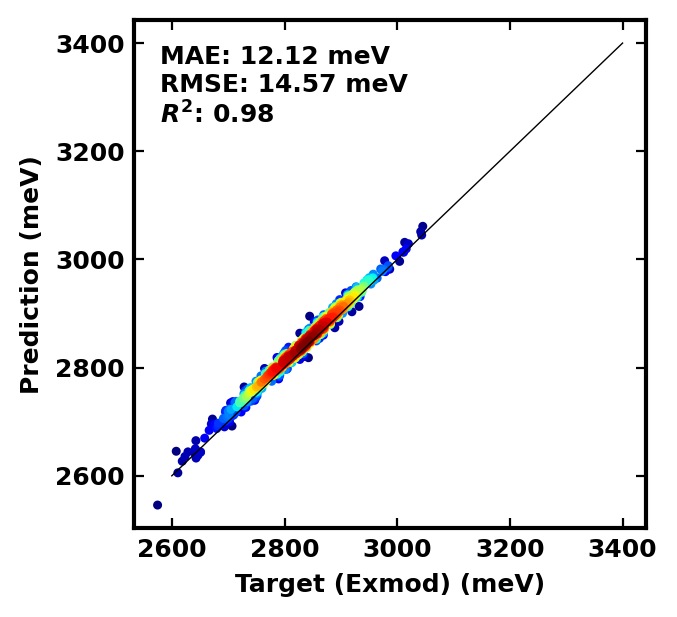

In [38]:
# plot delicate figures
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib import rc

rc('axes', linewidth=1.5)
myfont = 'Arial'
plt.rcParams['pdf.fonttype'] = 'truetype'
plt.rcParams['ps.fonttype'] = 'truetype'
# plt.rcParams['font.family'] = myfont
plt.rcParams["font.size"] = 9
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"

fig, ax = plt.subplots(1, 1, figsize = (3.3, 3.3), dpi = 200)

xmin, xmax = 2600, 3400
xs, ys = accu_es, pred_es

# ys -= np.mean(ys - xs)
zs = gaussian_kde(np.vstack([xs, ys]))(np.vstack([xs, ys]))
idx = zs.argsort()
xs, ys, zs = xs[idx], ys[idx], zs[idx]
ax.scatter(xs, ys, c = zs, s = 5, alpha = 1.0, cmap = "jet")
ax.plot([xmin, xmax], [xmin, xmax], color = "black", linewidth = 0.5)
# ax.axis([xmin, xmax, xmin, xmax])
ax.tick_params(axis = "both", which = "both", direction = "in", top = True, right = True)
ax.set_xlabel("Target (Exmod) (meV)")
ax.set_ylabel("Prediction (meV)")

mae  = np.mean(np.abs(ys - xs))
rmse = np.sqrt(np.mean((ys - xs)**2))
r2   = np.corrcoef(xs, ys)[0,1]**2
ax.text(0.05, 0.95, f"MAE: {mae:.2f} meV\nRMSE: {rmse:.2f} meV\n$R^2$: {r2:.2f}", transform = ax.transAxes, ha = "left", va = "top")


Text(0.05, 0.95, 'MAE: 15.28 meV\nRMSE: 18.87 meV\n$R^2$: 0.96')

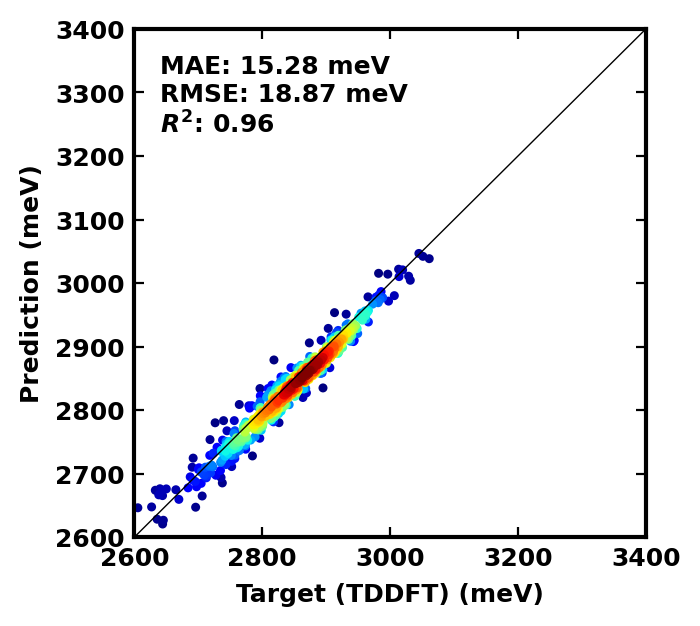

In [39]:
fig, ax = plt.subplots(1, 1, figsize = (3.3, 3.3), dpi = 200)

xmin, xmax = 2600, 3400
xs, ys = pred_es, data_e.loc[(1, "e"), :].values * 27.2114 * 1000

# ys -= np.mean(ys - xs)
zs = gaussian_kde(np.vstack([xs, ys]))(np.vstack([xs, ys]))
idx = zs.argsort()
xs, ys, zs = xs[idx], ys[idx], zs[idx]
ax.scatter(xs, ys, c = zs, s = 5, alpha = 1.0, cmap = "jet")
ax.plot([xmin, xmax], [xmin, xmax], color = "black", linewidth = 0.5)
ax.axis([xmin, xmax, xmin, xmax])
ax.tick_params(axis = "both", which = "both", direction = "in", top = True, right = True)
ax.set_xlabel("Target (TDDFT) (meV)")
ax.set_ylabel("Prediction (meV)")

mae  = np.mean(np.abs(ys - xs))
rmse = np.sqrt(np.mean((ys - xs)**2))
r2   = np.corrcoef(xs, ys)[0,1]**2
ax.text(0.05, 0.95, f"MAE: {mae:.2f} meV\nRMSE: {rmse:.2f} meV\n$R^2$: {r2:.2f}", transform = ax.transAxes, ha = "left", va = "top")
